# Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr, kendalltau, pearsonr
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, cv
import xgboost as xgb

# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Разведочный анализ данных:

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

expected_target_agent_1_df = pd.read_csv('train_expected_target_agent_1.csv')
expected_target_agent_2_df = pd.read_csv('train_expected_target_agent_2.csv')
target_agent_1_df = pd.read_csv('train_target_agent_1.csv')
target_agent_2_df = pd.read_csv('train_target_agent_2.csv')
train_target_df = pd.read_csv('train_target.csv')

In [3]:
sample_submission_df

,id,category
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
...,...,...
565,565,1.0
566,566,1.0
567,567,1.0
568,568,1.0


In [4]:
# создаем 
dataframes = {
    "Train Data": train_df,
    "Test Data": test_df,
    "Sample Submission": sample_submission_df,
    "Train Target": train_target_df,
    "Train Target Agent 1": target_agent_1_df,
    "Train Target Agent 2": target_agent_2_df,
    "Train Expected Target Agent 1": expected_target_agent_1_df,
    "Train Expected Target Agent 2": expected_target_agent_2_df,
}

In [5]:
# Проверка на наличие пропущенных значений в датафреймах
missing_values = {name: df.isnull().sum().sum() for name, df in dataframes.items()}
missing_values

{'Train Data': 1260,
 'Test Data': 180,
 'Sample Submission': 0,
 'Train Target': 0,
 'Train Target Agent 1': 0,
 'Train Target Agent 2': 0,
 'Train Expected Target Agent 1': 0,
 'Train Expected Target Agent 2': 0}

In [6]:
# Делаем копию датафрейма
train_df_copy = train_df.copy()

Пропуски содеражться в train и test датафреймах, посмотрим сколько их и возможно ли будет восстановить или лучше дропнуть.

In [7]:
# Получение размерности каждого датафрейма
dataframe_dimensions = {name: df.shape for name, df in dataframes.items()}
dataframe_dimensions

{'Train Data': (2470, 234),
 'Test Data': (570, 234),
 'Sample Submission': (570, 2),
 'Train Target': (2470, 2),
 'Train Target Agent 1': (2470, 1),
 'Train Target Agent 2': (2470, 1),
 'Train Expected Target Agent 1': (2470, 1),
 'Train Expected Target Agent 2': (2470, 1)}

In [8]:
def check_missing_values(df):
    # Вычисляем количество пропущенных значений для каждого столбца
    missing_values = df.isnull().sum()

    # Вычисляем процент пропущенных значений для каждого столбца
    total_values = len(df)
    missing_percent = ((missing_values / total_values) * 100).round(2)

    # Создаем новый столбец "строк пропущено" и вычисляем количество строк с хотя бы одним пропущенным значением
    missing_data = pd.DataFrame({'Столбец': missing_values.index, 'Пропущено в %': missing_percent.values})
    missing_data['Строк пропущено'] = df.isnull().any(axis=1).sum()

    # Сортируем датафрейм по убыванию процента пропущенных значений
    missing_data = missing_data.sort_values(by='Пропущено в %', ascending=False)

    return missing_data

# Используем функцию для анализа датафрейма train_df_cleaned
missing_data_summary = check_missing_values(train_df_copy)
missing_data_summary

,Столбец,Пропущено в %,Строк пропущено
233,agent_2_featboth_scored_mean,5.67,144
228,agent_2_feattotal_xg_mean,5.67,144
203,agent_1_feat_both_scored_mean.1,5.67,144
193,agent_1_feat_total_scored_mean.1,5.67,144
223,agent_2_feattotal_scored_mean,5.67,144
...,...,...,...
82,agent_2_feat_TotalTackles,0.00,144
83,agent_2_feat_DribbledPast,0.00,144
84,agent_2_feat_UnsuccessfulTouches,0.00,144
85,agent_2_feat_Dispossessed,0.00,144


Пропуски в некоторых фичах train составляют по 5,67% от общего числа данных, а в test по 3,51. На основании этого, допускаем возможность восстановить данные посредствам заполнения пропусков медианным значением.

In [9]:
# Заполнение пропущенных значений медианными значениями
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

# Проверка на наличие пропущенных значений после заполнения
missing_values_after_filling = {
    "Train Data": train_df.isnull().sum().sum(),
    "Test Data": test_df.isnull().sum().sum()
}
missing_values_after_filling

{'Train Data': 0, 'Test Data': 0}

In [10]:
# Объединяем датафреймы
train_df['target'] = train_target_df['category']

In [11]:
# Объединяем датафреймы
train_df['train_expected_target_agent_1'] = expected_target_agent_1_df
train_df['train_expected_target_agent_2'] = expected_target_agent_2_df
train_df['target_agent_1_df'] = target_agent_2_df
train_df['target_agent_2_df'] = target_agent_2_df
train_df.head()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,target,train_expected_target_agent_1,train_expected_target_agent_2,target_agent_1_df,target_agent_2_df
0,58.8,85.1,15.8,6.99,1.143700,0.928715,7.13,14.16,267.0,194.0,...,0.473684,0.473684,0.473684,0.473684,0.5,1,1.166350,0.278076,2,2
1,44.8,71.1,23.4,6.84,0.954159,0.975350,9.99,7.66,191.0,287.0,...,0.578947,0.578947,0.578947,0.578947,0.5,1,1.278300,0.613273,2,2
2,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,7.34,179.0,298.0,...,0.368421,0.368421,0.368421,0.368421,0.5,0,1.900670,1.117570,1,1
3,50.2,77.5,24.4,6.87,1.037613,0.956836,9.60,9.53,195.0,239.0,...,0.210526,0.210526,0.210526,0.210526,0.5,0,0.423368,0.909774,1,1
4,44.9,75.0,17.2,6.77,0.983691,0.948837,12.24,8.76,161.0,283.0,...,0.421053,0.421053,0.421053,0.421053,0.5,1,1.683430,0.991901,2,2


In [12]:
# Задаем условие, при котором мы удаляем кейсы, 
# где (train_expected_target_agent_1 >1 & train_expected_target_agent_2 > 1 & target == 0)
train_df = train_df.loc[~((train_df['train_expected_target_agent_1'] > 1) &
                                    (train_df['train_expected_target_agent_2'] > 1) &
                                    (train_df['target'] == 0))]

In [13]:
# Делаем копию датафрейма
train_df_copy = train_df.copy()

In [14]:
# Получение основных статистических характеристик для всех числовых столбцов
train_df_copy.describe()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,target,train_expected_target_agent_1,train_expected_target_agent_2,target_agent_1_df,target_agent_2_df
count,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,...,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000
mean,50.050588,78.358257,18.460349,6.791307,1.006008,1.016722,10.903120,10.905582,250.418736,248.910675,...,0.512212,0.505355,0.500814,0.506127,0.514033,0.542048,1.479056,1.155713,1.235730,1.235730
std,5.513321,5.044625,3.348236,0.145070,0.129302,0.133491,2.365741,3.367655,104.596077,59.032008,...,0.458395,0.472988,0.486729,0.279734,0.223329,0.498337,0.903070,0.765992,1.184665,1.184665
min,39.100000,63.900000,12.800000,6.460000,0.603136,0.643087,6.400000,5.650000,125.000000,96.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,74.700000,15.800000,6.690000,0.917431,0.925717,9.310000,8.780000,178.000000,201.000000,...,0.000000,0.000000,0.000000,0.333333,0.400000,0.000000,0.780326,0.578212,0.000000,0.000000
50%,49.100000,78.200000,17.800000,6.760000,1.005811,1.023353,10.530000,10.160000,217.000000,259.000000,...,0.526316,0.526316,0.526316,0.526316,0.500000,1.000000,1.304530,0.983306,1.000000,1.000000
75%,54.400000,82.500000,20.900000,6.890000,1.098001,1.101591,12.390000,11.510000,293.000000,297.000000,...,1.000000,1.000000,1.000000,0.666667,0.636364,1.000000,2.031795,1.579125,2.000000,2.000000
max,66.400000,89.400000,27.600000,7.150000,1.375405,1.319958,19.000000,26.310000,582.000000,357.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.630490,5.517670,9.000000,9.000000


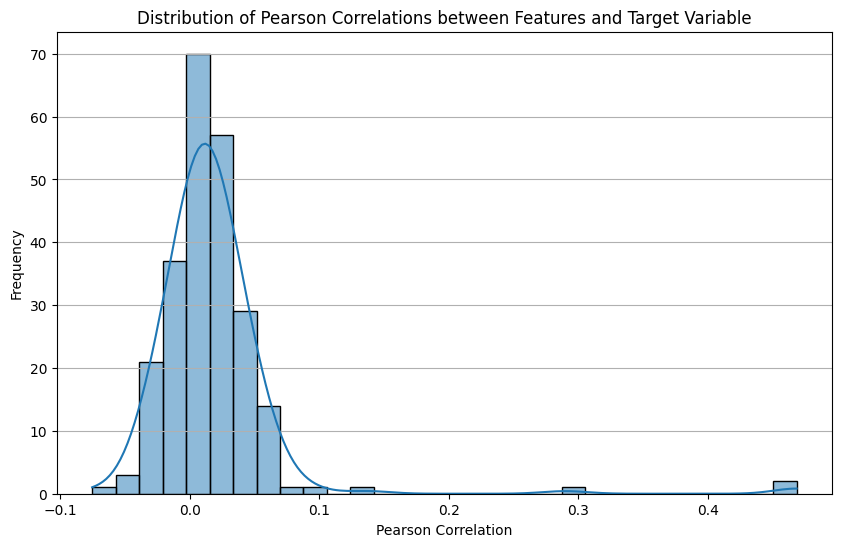

Top 20 positive correlation: 
target_agent_2_df                0.468697
target_agent_1_df                0.468697
train_expected_target_agent_2    0.289950
train_expected_target_agent_1    0.137335
agent_2_feat_XGrealiz            0.090848
agent_2_feat_ScoredAv            0.087271
agent_2_feat_XgAv                0.069280
agent_2_featscored_mean_3        0.068419
agent_2_featscored_2             0.067307
agent_2_feat_form_mean_3         0.066041
agent_2_feat_pl_10               0.062705
agent_2_feat_Short key passes    0.060517
agent_2_feat_pl_mean             0.057850
agent_2_feat_pl_7                0.056082
agent_2_feat_pl_median           0.053727
agent_2_feat_Possession%         0.053427
agent_2_feat_scored_mean_3       0.053325
agent_1_feat_MissedAv            0.052736
agent_2_feat_Rating              0.052340
agent_2_feat_pl_5                0.052046
Name: target, dtype: float64
----------------------------------------
Top 20 negative correlation: 
agent_2_feat_PPDA             

In [15]:
# Вычисление корреляций Пирсона между признаками и целевой переменной
pearson_correlations = train_df.corr(method='pearson')['target'].drop('target')

# Визуализация распределения корреляций
plt.figure(figsize=(10, 6))
sns.histplot(pearson_correlations, bins=30, kde=True)
plt.title('Distribution of Pearson Correlations between Features and Target Variable')
plt.xlabel('Pearson Correlation')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Вывод значений корреляций с наибольшей абсолютной величиной
top_20_positive_corr = pearson_correlations.sort_values(ascending=False).head(20)
top_20_negative_corr = pearson_correlations.sort_values(ascending=True).head(20)
print(f'Top 20 positive correlation: \n{top_20_positive_corr}')
print('-' * 40)
print(f'Top 20 negative correlation: \n{top_20_negative_corr}')

In [16]:
def SomersD(x, y):
    """
    Функция для вычисления статистики Сомерса D для определения важности признаков.
    
    Параметры:
    x (массивоподобный): Значения признаков
    y (массивоподобный): Значения целевой переменной
    
    Возвращает:
    float: Статистика Сомерса D
    """
    x = np.asarray(x).ravel()  # Преобразование входных данных в массивы NumPy
    y = np.asarray(y).ravel()

    if x.size != y.size:
        raise ValueError("Все входные данные должны иметь одинаковый размер, "
                         "обнаружен размер x: %s и размер y: %s" % (x.size, y.size))

    def count_rank_tie(ranks):
        cnt = np.bincount(ranks).astype('int64', copy=False)
        cnt = cnt[cnt > 1]
        return ((cnt * (cnt - 1) // 2).sum(),
                (cnt * (cnt - 1.) * (cnt - 2)).sum(),
                (cnt * (cnt - 1.) * (2*cnt + 5)).sum())

    size = x.size
    perm = np.argsort(y)  # сортировка по y и преобразование y в плотные ранги
    x, y = x[perm], y[perm]
    y = np.r_[True, y[1:] != y[:-1]].cumsum(dtype=np.intp)

    # стабильная сортировка по x и преобразование x в плотные ранги
    perm = np.argsort(x, kind='mergesort')
    x, y = x[perm], y[perm]
    x = np.r_[True, x[1:] != x[:-1]].cumsum(dtype=np.intp)

    dis = _kendall_dis(x, y)  # диссонирующие пары

    obs = np.r_[True, (x[1:] != x[:-1]) | (y[1:] != y[:-1]), True]
    cnt = np.diff(np.where(obs)[0]).astype('int64', copy=False)

    ntie = (cnt * (cnt - 1) // 2).sum()  # совместные связи
    xtie, x0, x1 = count_rank_tie(x)     # связи в x, статистика
    ytie, y0, y1 = count_rank_tie(y)     # связи в y, статистика

    tot = (size * (size - 1)) // 2
    SD = (tot - xtie - ytie + ntie - 2 * dis) / (tot - ntie)
    return SD

In [17]:
# Получаем список признаков
features = train_df_copy.columns.tolist()[:-1]  # все столбцы кроме последнего ('target')

# Создаем словарь для хранения результатов
results_dict = {}

# Цикл по признакам для вычисления корреляций и коэффициента Somers' D
for feature in features:
    spearman_corr, _ = spearmanr(train_df_copy[feature], train_df_copy['target'])
    kendall_corr, _ = kendalltau(train_df_copy[feature], train_df_copy['target'])
    pearson_corr, _ = pearsonr(train_df_copy[feature], train_df_copy['target'])
    somersd_corr = SomersD(train_df_copy[feature], train_df_copy['target'])
    
    results_dict[feature] = [spearman_corr, kendall_corr, pearson_corr, somersd_corr]

# Переводим словарь в DataFrame для удобства отображения
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['Pearson', 'Spearman', 'Kendall', 'SomersD'])

# Взятие абсолютных значений корреляций
for col in ['Pearson', 'Spearman', 'Kendall', 'SomersD']:
    results_df[col] = results_df[col].abs()

# Сортировка DataFrame по корреляции Пирсона (можно выбрать другой столбец для сортировки)
results_df = results_df.sort_values(by='Pearson', ascending=False)

# Показываем DataFrame
results_df

,Pearson,Spearman,Kendall,SomersD
target,1.000000,1.000000,1.000000,1.000000
target_agent_1_df,0.584490,0.534735,0.468697,0.410285
train_expected_target_agent_2,0.365322,0.298350,0.289950,0.210263
train_expected_target_agent_1,0.189401,0.154679,0.137335,0.109011
agent_2_feat_ScoredAv,0.110835,0.091598,0.087271,0.064568
...,...,...,...,...
agent_1_feat_form_2,0.000345,0.000321,0.000362,0.000223
agent_1_feat_pl_5,0.000297,0.000251,0.005818,0.000177
agent_1_feat_scored_mean_3.1,0.000255,0.000217,0.002004,0.000153
agent_1_feat_missed_3,0.000204,0.000183,0.002876,0.000128


Из полученных статистических данных видим, что линейной зависимости - нет.

# Предобработка данных:

На основании статистических данных и планируемых моделях (которые чувствительны к масштабу признаков, такие как, например, SVM или kNN) для построения, изначально нормализуем данные при помощи StandartScaler, т.к. у нас большое количество признаков с разными масштабами. (но, можно будет попробовать и с MinMaxScaler).

In [18]:
# дропаем столбцы 'train_expected_target_agent_1','train_expected_target_agent_2',
# 'target_agent_1_df', 'target_agent_2_df за ненадобностью
columns_to_drop = ['train_expected_target_agent_1', 'train_expected_target_agent_2', 'target_agent_1_df', 'target_agent_2_df']
train_df_copy = train_df_copy.drop(columns=columns_to_drop)

### StandartScaler (когда будем тестировать MinMaxScalder, закомментить)

In [19]:
# Создаем объекты scaler
standard_scaler = StandardScaler()

# Получаем список всех числовых столбцов
numeric_columns = train_df_copy.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'target']

# Применяем StandardScaler к числовым столбцам
train_df_copy[numeric_columns] = standard_scaler.fit_transform(
    train_df_copy[numeric_columns]
)

In [20]:
# тоже самое делаем с test.df
numeric_columns_2 = test_df.select_dtypes(include=[np.number]).columns

# Применяем StandardScaler к числовым столбцам
test_df[numeric_columns] = standard_scaler.fit_transform(
    test_df[numeric_columns]
)

In [21]:
train_df_copy.head()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_2_feattotal_xg_2,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,target
0,1.587304,1.336712,-0.794725,1.369933,1.065121,-0.659418,-1.595247,0.966586,0.158561,-0.930387,...,0.080147,0.078807,0.129783,-0.017504,-0.084067,-0.066973,-0.055751,-0.116003,-0.062851,1
1,-0.952553,-1.439124,1.475621,0.335724,-0.401075,-0.309990,-0.386060,-0.963961,-0.568202,0.645372,...,-0.348286,-0.335321,-0.564125,-0.017504,0.145617,0.155625,0.160562,0.260377,-0.062851,1
3,0.027106,-0.170170,1.774351,0.542566,0.244487,-0.448712,-0.550949,-0.408558,-0.529951,-0.167923,...,-0.476323,-0.459083,-0.771499,-0.017504,-0.658278,-0.623468,-0.596535,-1.056952,-0.062851,0
4,-0.934411,-0.665855,-0.376504,-0.146907,-0.172627,-0.508646,0.565223,-0.637253,-0.855082,0.577598,...,-0.063926,-0.060456,-0.103565,-0.017504,-0.198910,-0.178272,-0.163908,-0.304193,-0.062851,1
6,1.024907,1.078956,0.400194,2.473090,0.086517,-0.066561,-1.142859,-0.096700,1.411271,-1.320092,...,-0.261305,-0.251245,-0.423248,-0.017504,0.030775,0.044326,0.052405,0.072187,-0.062851,1


In [22]:
train_df_copy.to_csv('проверочный_2.csv',index=False)

### MinMaxScaler (расскоментить для тестов)

In [23]:
# # Создаем объекты scaler
# minmax_scaler = MinMaxScaler()

# # Применяем MinMaxScaler к числовым столбцам
# train_df_copy[numeric_columns] = minmax_scaler.fit_transform(
#     train_df_copy[numeric_columns]
# )

In [24]:
# Определение X и y
X = train_df_copy.drop(columns=['target'])
y = train_df_copy['target']

# Применяем train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Проверка размерности
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1836, 234), (459, 234), (1836,), (459,))

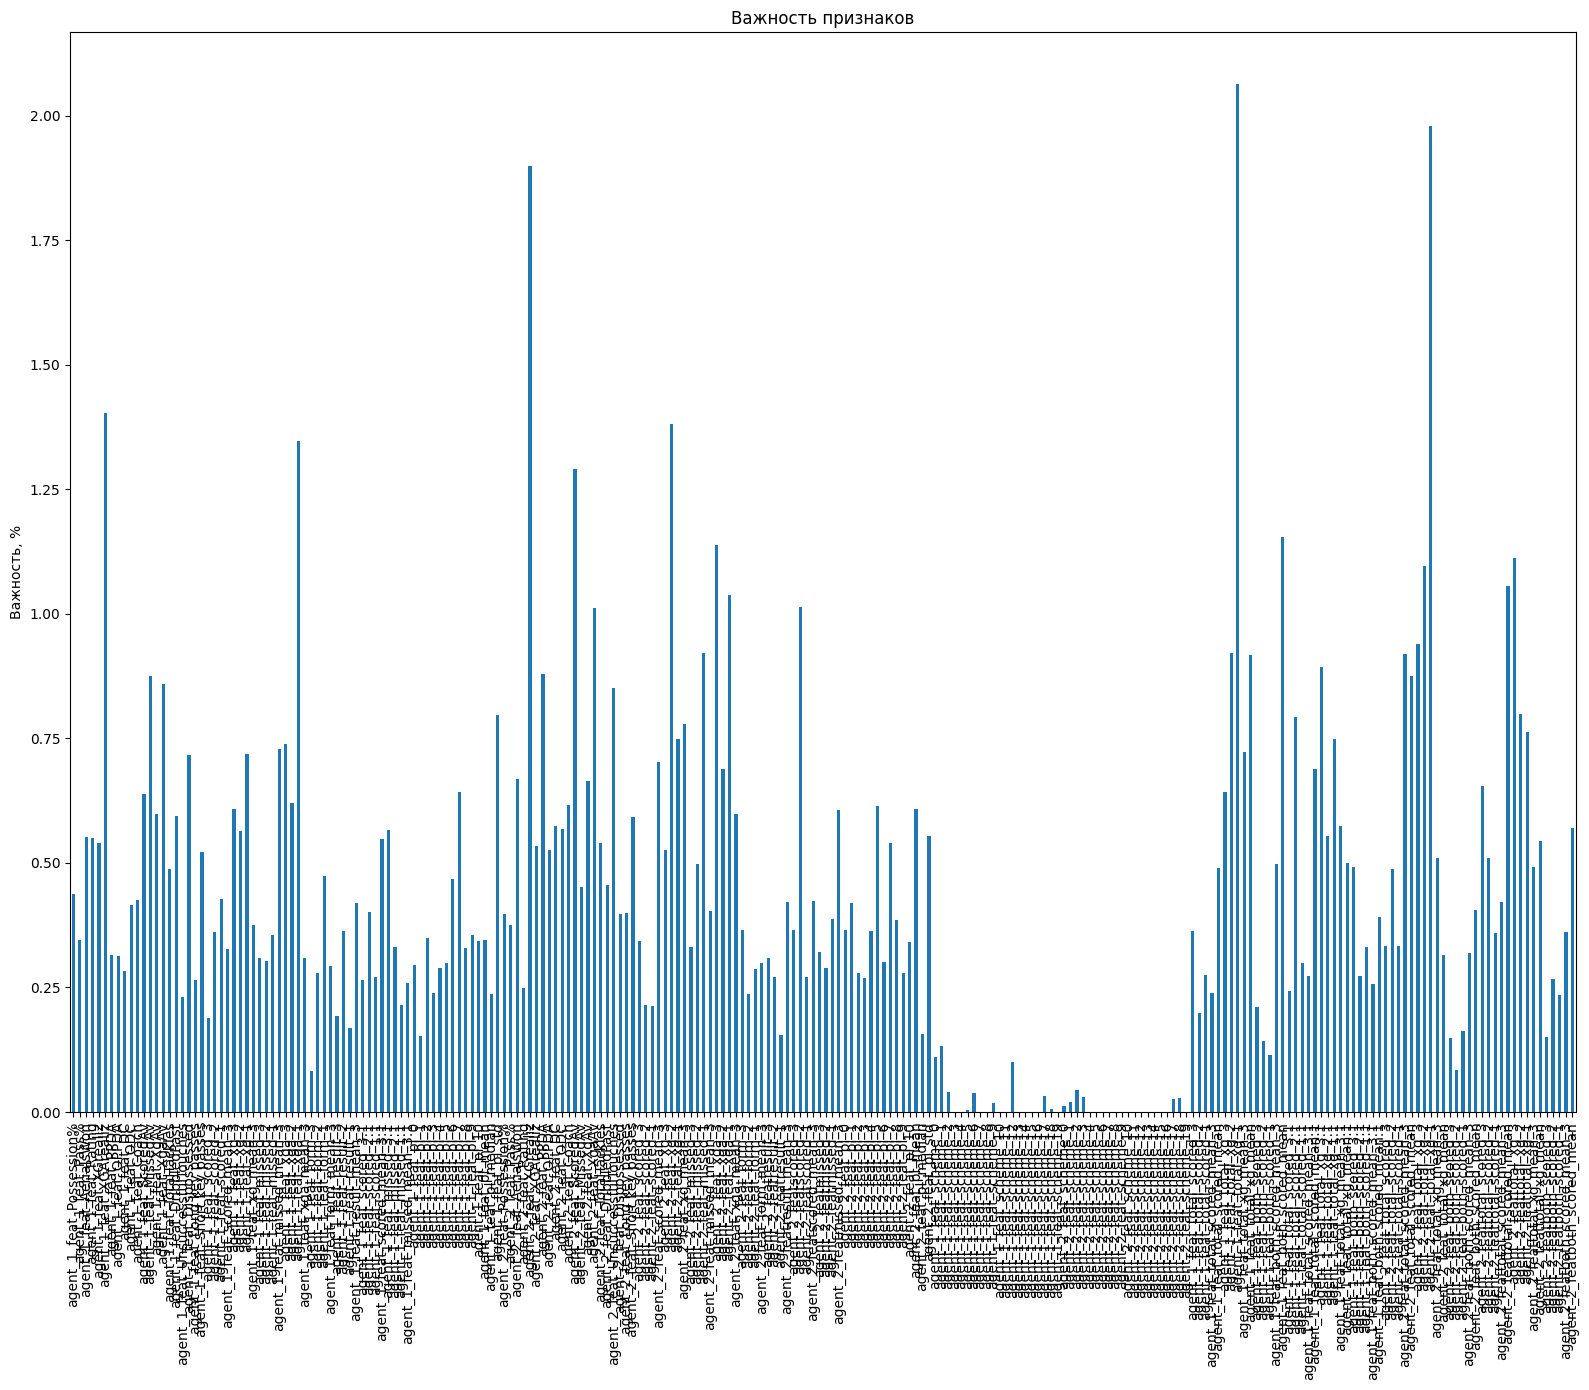

In [25]:
# Обучение модели
model_cat = CatBoostClassifier(verbose=0)  # verbose=0 отключит вывод прогресса обучения
model_cat.fit(X_train, y_train)

# Получение важности признаков
cat_imp = pd.Series(model_cat.get_feature_importance(), index=X_train.columns)

# Построение графика
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()
plt.show()

In [26]:
# Отбор признаков с важностью выше 30%
important_features = cat_imp[cat_imp > 0.3]

# Получение списка важных признаков
important_features_list = important_features.index.tolist()
important_features_list

['agent_1_feat_Possession%',
 'agent_1_feat_Pass%',
 'agent_1_feat_AerialsWon',
 'agent_1_feat_Rating',
 'agent_1_feat_XGrealiz',
 'agent_1_feat_XGArealiz',
 'agent_1_feat_PPDA',
 'agent_1_feat_OPPDA',
 'agent_1_feat_ODC',
 'agent_1_feat_Coach',
 'agent_1_feat_ScoredAv',
 'agent_1_feat_MissedAv',
 'agent_1_feat_XgAv',
 'agent_1_feat_XgaAv',
 'agent_1_feat_TotalTackles',
 'agent_1_feat_DribbledPast',
 'agent_1_feat_Dispossessed',
 'agent_1_feat_Short key passes',
 'agent_1_feat_scored_2',
 'agent_1_feat_scored_1',
 'agent_1_feat_scored_mean_3',
 'agent_1_feat_xg_3',
 'agent_1_feat_xg_2',
 'agent_1_feat_xg_1',
 'agent_1_feat_xg_mean_3',
 'agent_1_feat_missed_3',
 'agent_1_feat_missed_2',
 'agent_1_feat_missed_1',
 'agent_1_feat_missed_mean_3',
 'agent_1_feat_xga_3',
 'agent_1_feat_xga_2',
 'agent_1_feat_xga_1',
 'agent_1_feat_xga_mean_3',
 'agent_1_feat_form_1',
 'agent_1_feat_result_2',
 'agent_1_feat_result_mean_3',
 'agent_1_feat_scored_2.1',
 'agent_1_feat_scored_mean_3.1',
 'agent_1

In [27]:
# Отбор только тех признаков, на которых обучалась модель в test.csv
test_df_selected_features = test_df[important_features_list]

In [28]:
# Отбор только важных признаков
train_df_copy_selected_features = train_df_copy[important_features_list]
train_df_copy_selected_features

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_ODC,agent_1_feat_Coach,...,agent_2_feattotal_scored_1,agent_2_feattotal_scored_mean_3,agent_2_feattotal_scored_mean,agent_2_feattotal_xg_3,agent_2_feattotal_xg_2,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean
0,1.587304,1.336712,-0.794725,1.369933,1.065121,-0.659418,-1.595247,0.966586,-0.930387,1.935689,...,-0.164485,-0.309111,-0.067838,0.081623,0.080147,0.078807,0.129783,-0.017504,-0.116003,-0.062851
1,-0.952553,-1.439124,1.475621,0.335724,-0.401075,-0.309990,-0.386060,-0.963961,0.645372,-0.623974,...,-0.031822,-0.076391,-0.067838,-0.362638,-0.348286,-0.335321,-0.564125,-0.017504,0.260377,-0.062851
3,0.027106,-0.170170,1.774351,0.542566,0.244487,-0.448712,-0.550949,-0.408558,-0.167923,-0.206301,...,-0.197651,-0.367291,-0.067838,-0.495406,-0.476323,-0.459083,-0.771499,-0.017504,-1.056952,-0.062851
4,-0.934411,-0.665855,-0.376504,-0.146907,-0.172627,-0.508646,0.565223,-0.637253,0.577598,0.020880,...,-0.330315,-0.600012,-0.067838,-0.067773,-0.063926,-0.060456,-0.103565,-0.017504,-0.304193,-0.062851
6,1.024907,1.078956,0.400194,2.473090,0.086517,-0.066561,-1.142859,-0.096700,-1.320092,0.931014,...,-0.031822,-0.076391,-0.067838,-0.272444,-0.261305,-0.251245,-0.423248,-0.017504,0.072187,-0.062851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,-1.533092,-0.467581,-0.406377,-1.181117,0.312500,0.121884,3.000508,-0.782787,1.238400,-1.103005,...,0.200339,2.910191,1.793032,4.133499,-0.730239,1.051099,2.344916,2.550567,-0.617843,-0.311667
2466,-1.297248,-0.447754,-0.047901,-1.250064,1.205148,0.370995,2.214114,-0.981782,0.391218,-0.516768,...,-1.059964,-1.511501,-0.247199,0.026315,-0.979526,-1.125747,-1.143889,-0.205879,-1.809712,-0.311667
2467,-1.641943,-1.221022,0.191083,-1.939537,-0.039836,0.073055,2.150695,-0.865949,1.594217,-0.789437,...,0.830491,-1.143027,-0.975852,-0.871017,-0.980052,1.243191,-0.288243,-0.241608,-0.617843,-0.062851
2468,0.244808,0.186723,-1.302566,-1.181117,0.247367,1.084041,-0.495986,-0.129371,0.442048,0.301238,...,0.830491,-0.037604,-0.830122,-0.829262,-0.586023,2.305059,0.539309,-0.368857,-0.617843,-1.306930


In [29]:
# Список всех фичей
features_list =train_df_copy_selected_features.columns.tolist()

# Подсчет фичей для agent_1 и agent_2
agent_1_features = [feature for feature in features_list if feature.startswith('agent_1')]
agent_2_features = [feature for feature in features_list if feature.startswith('agent_2')]

# Вывод количества фичей для каждого агента
print(f"Number of features for agent_1: {len(agent_1_features)}")
print(f"Number of features for agent_2: {len(agent_2_features)}")

Number of features for agent_1: 67
Number of features for agent_2: 77


In [30]:
# Определение X и y
X = train_df_copy_selected_features
y = train_df_copy['target']

# Применяем train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Проверка размерности
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1836, 144), (459, 144), (1836,), (459,))

# Построение моделей:

### Логистическая регрессия

In [31]:
# Создание и обучение линейной модели с увеличенным числом итераций
linear_model = LogisticRegression(random_state=42, max_iter=1000)
linear_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = linear_model.predict(X_test)

# Оценка модели
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.41      0.46       210
           1       0.57      0.66      0.61       249

    accuracy                           0.55       459
   macro avg       0.54      0.54      0.54       459
weighted avg       0.54      0.55      0.54       459



In [32]:
# Предсказание целевой переменной на тестовых данных
test_predictions = linear_model.predict(test_df_selected_features)
# Создание датафрейма с ID (индексами) и предсказаниями
submission_df = pd.DataFrame({'id': test_df.index, 'category': test_predictions})
submission_df

,id,category
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
565,565,0
566,566,0
567,567,0
568,568,0


In [33]:
submission_df.to_csv('submission_df_linearmodel.csv', index=False)

In [34]:
submission_df['category'].unique()

array([0, 1], dtype=int64)

55% accuracy на тестовом наборе - это слишком мало, нужно дойти хотябы до 65%. Попробуем другой способ, Нейронную сеть

### Нейронная сеть

In [35]:
# Определение архитектуры нейронной сети
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(144, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Подготовка данных для обучения и тестирования
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Обучение модели
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    for batch in train_loader:
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Получение выходов модели
        outputs = model(batch[0])
        
        # Вычисление потерь
        loss = criterion(outputs, batch[1])
        
        # Обратное распространение ошибки и оптимизация
        loss.backward()
        optimizer.step()

# Проверка модели на тестовых данных
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f"Test Loss: {test_loss.item()}")

Test Loss: 2.5103485584259033


In [36]:

# Получение предсказанных меток
y_pred = (test_outputs.numpy() > 0.5).astype(int)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, recall, precision, f1

(0.5010893246187363,
 0.5100401606425703,
 0.5427350427350427,
 0.5258799171842651)

In [37]:
# Определение новой архитектуры нейронной сети с добавлением dropout слоев
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(144, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet()

# Обучение модели
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    for batch in train_loader:
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Получение выходов модели
        outputs = model(batch[0])
        
        # Вычисление потерь
        loss = criterion(outputs, batch[1])
        
        # Обратное распространение ошибки и оптимизация
        loss.backward()
        optimizer.step()

# Проверка модели на тестовых данных
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

# Получение предсказанных меток
y_pred = (test_outputs.numpy() > 0.5).astype(int)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

test_loss.item(), accuracy, recall, precision, f1

(0.6907570958137512,
 0.5490196078431373,
 0.7630522088353414,
 0.5621301775147929,
 0.6473594548551959)

In [38]:
# Определение сетки параметров для поиска
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01],
    'epochs': [20, 30, 40],
    'batch_size': [16, 32, 64]
}

# Создание сетки параметров
param_grid = ParameterGrid(param_grid)
param_grid = list(param_grid)

# Показ первых нескольких наборов параметров
param_grid[:3]

[{'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001},
 {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.005},
 {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.01}]

In [39]:
# Определение архитектуры нейронной сети
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(144, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Функция для обучения и оценки модели
def train_and_evaluate_model(params):
    # Инициализация модели, функции потерь и оптимизатора
    model = NeuralNet()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    # Создание DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    # Обучение модели
    for epoch in range(params['epochs']):
        model.train()
        for batch in train_loader:
            # Обнуление градиентов
            optimizer.zero_grad()

            # Получение выходов модели
            outputs = model(batch[0])

            # Вычисление потерь
            loss = criterion(outputs, batch[1])

            # Обратное распространение ошибки и оптимизация
            loss.backward()
            optimizer.step()

    # Проверка модели на тестовых данных
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

    # Получение предсказанных меток
    y_pred = (test_outputs.numpy() > 0.5).astype(int)

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return test_loss.item(), accuracy, recall, precision, f1

# Тестирование функции на первом наборе параметров
train_and_evaluate_model(param_grid[0])

(1.0793671607971191,
 0.5206971677559913,
 0.5903614457831325,
 0.5547169811320755,
 0.5719844357976654)

In [40]:
# Создание списка для сохранения результатов
results = []

# Перебор всех наборов параметров в сетке
for params in tqdm(param_grid):
    # Обучение и оценка модели с текущим набором параметров
    metrics = train_and_evaluate_model(params)
    
    # Сохранение текущих параметров и метрик
    results.append({'params': params, 'loss': metrics[0], 'accuracy': metrics[1], 
                    'recall': metrics[2], 'precision': metrics[3], 'f1_score': metrics[4]})

# Преобразование результатов в DataFrame для удобства анализа
results_df = pd.DataFrame(results)

# Вывод первых нескольких строк результатов
results_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:11<00:00,  2.64s/it]


,params,loss,accuracy,recall,precision,f1_score
0,"{'batch_size': 16, 'epochs': 20, 'learning_rat...",1.087220,0.509804,0.602410,0.543478,0.571429
1,"{'batch_size': 16, 'epochs': 20, 'learning_rat...",1.186246,0.511983,0.590361,0.546468,0.567568
2,"{'batch_size': 16, 'epochs': 20, 'learning_rat...",1.086789,0.516340,0.787149,0.536986,0.638436
3,"{'batch_size': 16, 'epochs': 30, 'learning_rat...",1.228913,0.509804,0.538153,0.549180,0.543611
4,"{'batch_size': 16, 'epochs': 30, 'learning_rat...",1.325966,0.488017,0.586345,0.525180,0.554080


In [41]:
results_df = results_df.sort_values(by='accuracy')
results_df

,params,loss,accuracy,recall,precision,f1_score
24,"{'batch_size': 64, 'epochs': 40, 'learning_rat...",1.330368,0.472767,0.514056,0.514056,0.514056
4,"{'batch_size': 16, 'epochs': 30, 'learning_rat...",1.325966,0.488017,0.586345,0.525180,0.554080
25,"{'batch_size': 64, 'epochs': 40, 'learning_rat...",1.658062,0.488017,0.602410,0.524476,0.560748
7,"{'batch_size': 16, 'epochs': 40, 'learning_rat...",1.418099,0.496732,0.485944,0.540179,0.511628
20,"{'batch_size': 64, 'epochs': 20, 'learning_rat...",1.281003,0.498911,0.493976,0.541850,0.516807
15,"{'batch_size': 32, 'epochs': 40, 'learning_rat...",1.558672,0.498911,0.570281,0.535849,0.552529
11,"{'batch_size': 32, 'epochs': 20, 'learning_rat...",1.083977,0.503268,0.642570,0.535117,0.583942
14,"{'batch_size': 32, 'epochs': 30, 'learning_rat...",1.009359,0.507625,0.710843,0.534743,0.610345
0,"{'batch_size': 16, 'epochs': 20, 'learning_rat...",1.087220,0.509804,0.602410,0.543478,0.571429
3,"{'batch_size': 16, 'epochs': 30, 'learning_rat...",1.228913,0.509804,0.538153,0.549180,0.543611


In [42]:
results_df['params'][2]

{'batch_size': 16, 'epochs': 20, 'learning_rate': 0.01}

In [43]:
# Параметры лучшей модели
best_params = {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.01}

# Тестирование функции с лучшими параметрами
metrics = train_and_evaluate_model(best_params)

In [44]:
metrics

(0.7089189291000366,
 0.5163398692810458,
 0.8433734939759037,
 0.5343511450381679,
 0.6542056074766355)

In [45]:
# 1. Преобразование тестового датафрейма в тензор PyTorch
X_test_new = torch.tensor(test_df_selected_features.values, dtype=torch.float32)

# 2. Получение прогнозов от обученной модели
model.eval()
with torch.no_grad():
    test_outputs_new = model(X_test_new)

# 3. Преобразование прогнозов обратно в pandas DataFrame
# Преобразование вероятностей в бинарные метки (можно адаптировать порог, если это необходимо)
y_pred_new = (test_outputs_new.numpy() > 0.5).astype(int)

# Создание нового DataFrame с прогнозами
predictions_df = pd.DataFrame(y_pred_new, columns=['target'])

In [46]:
# Получение индексов из тестового датафрейма
test_indices = test_df_selected_features.index

# Создание нового датафрейма с индексами и прогнозами
predictions_df = pd.DataFrame({
    'id': test_indices,
    'category': y_pred_new.squeeze()  # Убедись, что y_pred_new имеет правильную форму
})
predictions_df

,id,category
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
565,565,0
566,566,0
567,567,1
568,568,0


In [47]:
predictions_df.to_csv('submission_df_NN.csv', index=False)

# Классная мысль! Продолжить отсюда! СПОСОБ № 2

Разделение тренировочного датасета

In [48]:
# Получение признаков для каждого агента
agent_1_features = [col for col in train_df_copy.columns if 'agent_1_' in col]
agent_2_features = [col for col in train_df_copy.columns if 'agent_2_' in col]

# Создание датафреймов для каждого агента
agent_1_df = train_df[agent_1_features].copy()
agent_2_df = train_df[agent_2_features].copy()

# добавляем ожидание выигрыша
agent_1_df['target'] = expected_target_agent_1_df
agent_2_df['target'] = expected_target_agent_2_df

In [49]:
agent_1_df['target'] = np.where(agent_1_df['target'] >= 1.0, 1, 0)
agent_2_df['target'] = np.where(agent_2_df['target'] >= 1.0, 1, 0)

Разделение тестового датасета

In [50]:
# Получение признаков для каждого агента из test_df
agent_1_features_test = [col for col in test_df.columns if 'agent_1_' in col]
agent_2_features_test = [col for col in test_df.columns if 'agent_2_' in col]

# Создание датафреймов для каждого агента из test_df
agent_1_test_df = test_df[agent_1_features_test].copy()
agent_2_test_df = test_df[agent_2_features_test].copy()

In [51]:
def standardize_agents_dataframes_inplace_v2():
    # Создаем объект scaler
    scaler = StandardScaler()
    
    # Стандартизация agent_1_df, исключая целевую переменную 'target'
    numeric_columns_agent_1 = agent_1_df.select_dtypes(include=[np.number]).columns
    numeric_columns_agent_1 = [col for col in numeric_columns_agent_1 if col != 'target']
    agent_1_df[numeric_columns_agent_1] = scaler.fit_transform(agent_1_df[numeric_columns_agent_1])
    
    # Стандартизация agent_2_df, исключая целевую переменную 'target'
    numeric_columns_agent_2 = agent_2_df.select_dtypes(include=[np.number]).columns
    numeric_columns_agent_2 = [col for col in numeric_columns_agent_2 if col != 'target']
    agent_2_df[numeric_columns_agent_2] = scaler.fit_transform(agent_2_df[numeric_columns_agent_2])
    
    # Стандартизация agent_1_test_df
    agent_1_test_df[agent_1_test_df.columns] = scaler.fit_transform(agent_1_test_df)
    
    # Стандартизация agent_2_test_df
    agent_2_test_df[agent_2_test_df.columns] = scaler.fit_transform(agent_2_test_df)

# Применение функции
standardize_agents_dataframes_inplace_v2()

# Вывод первых 5 строк стандартизированного agent_1_df для проверки
agent_1_df.head()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_1_feat_total_xg_2.1,agent_1_feat_total_xg_1.1,agent_1_feat_total_xg_mean_3.1,agent_1_feat_total_xg_mean.1,agent_1_feat_both_scored_3.1,agent_1_feat_both_scored_2.1,agent_1_feat_both_scored_1.1,agent_1_feat_both_scored_mean_3.1,agent_1_feat_both_scored_mean.1,target
0,1.587304,1.336712,-0.794725,1.369933,1.065121,-0.659418,-1.595247,0.966586,0.158561,-0.930387,...,-0.085222,-0.073043,-0.138949,-0.033332,0.156435,0.158164,0.160184,0.277664,-0.060592,1
1,-0.952553,-1.439124,1.475621,0.335724,-0.401075,-0.309990,-0.386060,-0.963961,-0.568202,0.645372,...,-0.007269,0.002878,-0.010511,-0.033332,-0.073557,-0.064664,-0.056192,-0.113360,-0.060592,1
3,0.027106,-0.170170,1.774351,0.542566,0.244487,-0.448712,-0.550949,-0.408558,-0.529951,-0.167923,...,0.173025,0.178472,0.286547,-0.033332,0.156435,0.158164,0.160184,0.277664,-0.060592,0
4,-0.934411,-0.665855,-0.376504,-0.146907,-0.172627,-0.508646,0.565223,-0.637253,-0.855082,0.577598,...,-0.562262,-0.537647,-0.924936,-0.033332,-0.303549,-0.287492,-0.272567,-0.504385,-0.060592,1
6,1.024907,1.078956,0.400194,2.473090,0.086517,-0.066561,-1.142859,-0.096700,1.411271,-1.320092,...,0.308423,0.310340,0.509634,-0.033332,0.041439,0.046750,0.051996,0.082152,-0.060592,1


In [52]:
# agent_1_df.to_csv('agent_1_df.csv', index=False)
# agent_2_df.to_csv('agent_2_df.csv', index=False)

In [53]:
agent_1_df.shape

(2295, 118)

In [54]:
# Отфильтровать список важных признаков для agent_1
important_features_agent_1 = [feature for feature in important_features_list if feature.startswith('agent_1_')]

# Отфильтровать список важных признаков для agent_2
important_features_agent_2 = [feature for feature in important_features_list if feature.startswith('agent_2_')]
# Оставить только важные признаки в agent_1_df и agent_2_df
agent_1_df = agent_1_df[important_features_agent_1 + ['target']]  # добавляем 'target', так как это наша целевая переменная
agent_2_df = agent_2_df[important_features_agent_2 + ['target']]  # аналогично для agent_2

filtered_agent_1_df = agent_1_df.copy()
filtered_agent_2_df = agent_2_df.copy()

Epoch 1/20
58/58 [==============================] - 1s 4ms/step - loss: 3.0753 - accuracy: 0.5920 - val_loss: 2.7044 - val_accuracy: 0.6536
Epoch 2/20
58/58 [==============================] - 0s 1ms/step - loss: 2.4961 - accuracy: 0.6149 - val_loss: 2.2159 - val_accuracy: 0.6623
Epoch 3/20
58/58 [==============================] - 0s 1ms/step - loss: 2.0284 - accuracy: 0.6629 - val_loss: 1.8230 - val_accuracy: 0.6710
Epoch 4/20
58/58 [==============================] - 0s 1ms/step - loss: 1.6705 - accuracy: 0.6776 - val_loss: 1.5097 - val_accuracy: 0.6732
Epoch 5/20
58/58 [==============================] - 0s 1ms/step - loss: 1.3785 - accuracy: 0.6901 - val_loss: 1.2706 - val_accuracy: 0.6667
Epoch 6/20
58/58 [==============================] - 0s 1ms/step - loss: 1.1681 - accuracy: 0.6895 - val_loss: 1.0893 - val_accuracy: 0.6732
Epoch 7/20
58/58 [==============================] - 0s 1ms/step - loss: 1.0123 - accuracy: 0.6906 - val_loss: 0.9550 - val_accuracy: 0.6732
Epoch 8/20
58/58 [==

<AxesSubplot:title={'center':'Training and Validation Accuracy for Agent 1'}>

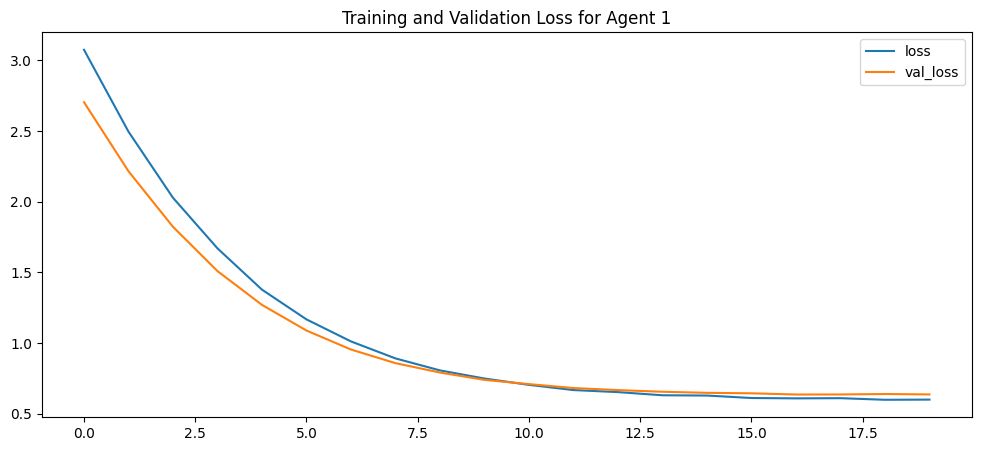

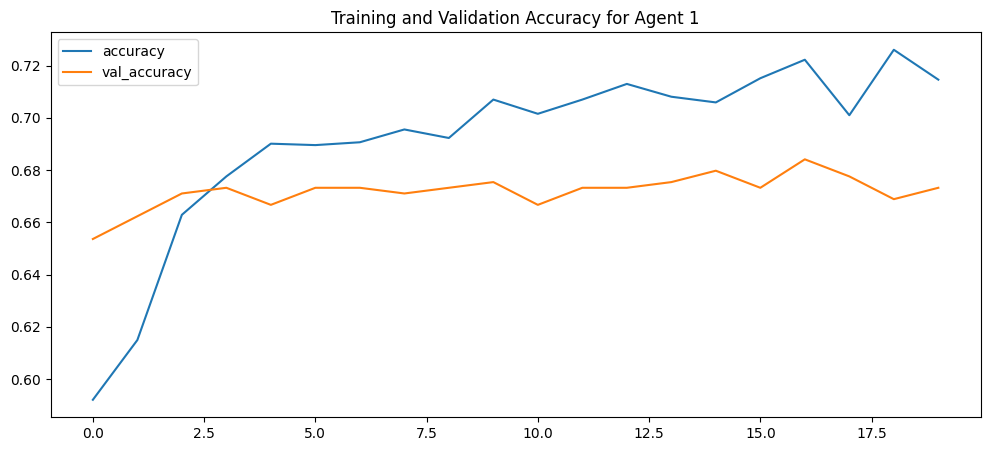

In [55]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Разделение данных
X1_train, X1_test, y1_train, y1_test = train_test_split(filtered_agent_1_df.drop("target", axis=1), filtered_agent_1_df["target"], test_size=0.2, random_state=42)
X2_train, X2_test = train_test_split(filtered_agent_2_df.drop("target", axis=1), test_size=0.2, random_state=42)

def build_improved_siamese_model(input_shape_1, input_shape_2):
    # Определение тензоров для двух входных наборов данных
    input_1 = tf.keras.layers.Input(shape=input_shape_1)
    input_2 = tf.keras.layers.Input(shape=input_shape_2)

    # Извлечение признаков для agent_1
    fe_1 = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4)
    ])

    # Извлечение признаков для agent_2
    fe_2 = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4)
    ])

    # Создание кодировок (векторов признаков) для двух наборов данных
    encoded_1 = fe_1(input_1)
    encoded_2 = fe_2(input_2)

    # Объединение векторов признаков
    concatenated = tf.keras.layers.Concatenate()([encoded_1, encoded_2])

    # Слой классификации
    out = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01))(concatenated)
    out = tf.keras.layers.Dropout(0.4)(out)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(out)

    # Построение и возврат модели
    return tf.keras.models.Model(inputs=[input_1, input_2], outputs=out)

# Build improved model for agent_1
model_agent_1_improved = build_improved_siamese_model(X1_train.shape[1:], X2_train.shape[1:])
model_agent_1_improved.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Ранняя остановка
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Обучение улучшенной модели для agent_1
history_agent_1_improved = model_agent_1_improved.fit([X1_train, X2_train], y1_train, validation_data=([X1_test, X2_test], y1_test), epochs=20, batch_size=32, callbacks=[early_stop])
# Отображение истории обучения для agent_1 с использованием построения DataFrame
history_agent_1_improved_df = pd.DataFrame(history_agent_1_improved.history)

# Построение графика потерь
history_agent_1_improved_df[['loss', 'val_loss']].plot(figsize=(12, 5), title='Training and Validation Loss for Agent 1')

# Построение графика точности
history_agent_1_improved_df[['accuracy', 'val_accuracy']].plot(figsize=(12, 5), title='Training and Validation Accuracy for Agent 1')

Epoch 1/20
58/58 [==============================] - 1s 4ms/step - loss: 3.1363 - accuracy: 0.5741 - val_loss: 2.7723 - val_accuracy: 0.6122
Epoch 2/20
58/58 [==============================] - 0s 1ms/step - loss: 2.5726 - accuracy: 0.5986 - val_loss: 2.3140 - val_accuracy: 0.6471
Epoch 3/20
58/58 [==============================] - 0s 1ms/step - loss: 2.1527 - accuracy: 0.6144 - val_loss: 1.9345 - val_accuracy: 0.6688
Epoch 4/20
58/58 [==============================] - 0s 1ms/step - loss: 1.7911 - accuracy: 0.6443 - val_loss: 1.6276 - val_accuracy: 0.6710
Epoch 5/20
58/58 [==============================] - 0s 1ms/step - loss: 1.4996 - accuracy: 0.6601 - val_loss: 1.3778 - val_accuracy: 0.6645
Epoch 6/20
58/58 [==============================] - 0s 1ms/step - loss: 1.2876 - accuracy: 0.6667 - val_loss: 1.1912 - val_accuracy: 0.6710
Epoch 7/20
58/58 [==============================] - 0s 1ms/step - loss: 1.1243 - accuracy: 0.6601 - val_loss: 1.0500 - val_accuracy: 0.6514
Epoch 8/20
58/58 [==

<AxesSubplot:>

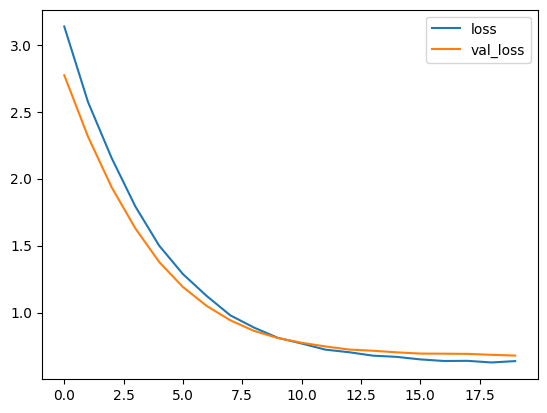

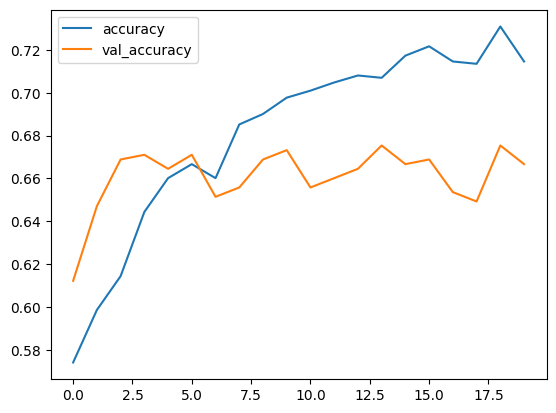

In [56]:
# Split data for agent_2
X1_train, X1_test, y2_train, y2_test = train_test_split(filtered_agent_1_df.drop("target", axis=1), filtered_agent_2_df["target"], test_size=0.2, random_state=42)
X2_train, X2_test = train_test_split(filtered_agent_2_df.drop("target", axis=1), test_size=0.2, random_state=42)

# Build improved model for agent_2
model_agent_2_improved = build_improved_siamese_model(X1_train.shape[1:], X2_train.shape[1:])
model_agent_2_improved.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the improved model for agent_2
history_agent_2_improved = model_agent_2_improved.fit([X1_train, X2_train], y2_train, validation_data=([X1_test, X2_test], y2_test), epochs=20, batch_size=32, callbacks=[early_stop])

# Displaying the training history
history_agent_2_improved_df = pd.DataFrame(history_agent_2_improved.history)
history_agent_2_improved_df[['loss', 'val_loss']].plot()
history_agent_2_improved_df[['accuracy', 'val_accuracy']].plot()

In [57]:
from sklearn.model_selection import KFold
# Разделение данных
X1 = filtered_agent_1_df.drop("target", axis=1)
y1 = filtered_agent_1_df["target"]
X2 = filtered_agent_2_df.drop("target", axis=1)

# Определение архитектуры модели
def build_improved_siamese_model(input_shape_1, input_shape_2):
    input_1 = tf.keras.layers.Input(shape=input_shape_1)
    input_2 = tf.keras.layers.Input(shape=input_shape_2)
   # Определение двух разных экземпляров модели fe
    fe_1 = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4)
    ])

    # Определение модели fe_2
    fe_2 = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.4)
    ])
    encoded_1 = fe_1(input_1)
    encoded_2 = fe_2(input_2)
    concatenated = tf.keras.layers.Concatenate()([encoded_1, encoded_2])
    out = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.01))(concatenated)
    out = tf.keras.layers.Dropout(0.4)(out)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(out)
    return tf.keras.models.Model(inputs=[input_1, input_2], outputs=out)

# Параметры
n_splits = 5
epochs = 20
batch_size = 32

# Инициализация KFold
kf = KFold(n_splits=n_splits)

# Кросс-валидация
validation_accuracies = []

for train_index, val_index in kf.split(X1):
    X1_train, X1_val = X1.iloc[train_index], X1.iloc[val_index]
    X2_train, X2_val = X2.iloc[train_index], X2.iloc[val_index]
    y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]

    # Строим и компилируем модель
    model = build_improved_siamese_model(X1_train.shape[1:], X2_train.shape[1:])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    # Обучение модели
    model.fit([X1_train, X2_train], y1_train, validation_data=([X1_val, X2_val], y1_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stop])

    # Оценка модели
    _, val_accuracy = model.evaluate([X1_val, X2_val], y1_val)
    validation_accuracies.append(val_accuracy)

# Вывод средней точности валидации
average_val_accuracy = np.mean(validation_accuracies)
print(f"Средняя точность валидации после {n_splits}-fold кросс-валидации: {average_val_accuracy:.4f}")

# Финальное обучение модели на всем обучающем наборе данных
final_model = build_improved_siamese_model(X1.shape[1:], X2.shape[1:])
final_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
final_model.fit([X1, X2], y1, epochs=epochs, batch_size=batch_size)

Epoch 1/20
58/58 [==============================] - 1s 6ms/step - loss: 3.0713 - accuracy: 0.5790 - val_loss: 2.7041 - val_accuracy: 0.6449
Epoch 2/20
58/58 [==============================] - 0s 2ms/step - loss: 2.5087 - accuracy: 0.6285 - val_loss: 2.2449 - val_accuracy: 0.6797
Epoch 3/20
58/58 [==============================] - 0s 2ms/step - loss: 2.0612 - accuracy: 0.6650 - val_loss: 1.8677 - val_accuracy: 0.6776
Epoch 4/20
58/58 [==============================] - 0s 2ms/step - loss: 1.7175 - accuracy: 0.6699 - val_loss: 1.5617 - val_accuracy: 0.6754
Epoch 5/20
58/58 [==============================] - 0s 1ms/step - loss: 1.4355 - accuracy: 0.6819 - val_loss: 1.3238 - val_accuracy: 0.6841
Epoch 6/20
58/58 [==============================] - 0s 1ms/step - loss: 1.2292 - accuracy: 0.6863 - val_loss: 1.1396 - val_accuracy: 0.6776
Epoch 7/20
58/58 [==============================] - 0s 1ms/step - loss: 1.0556 - accuracy: 0.6879 - val_loss: 1.0015 - val_accuracy: 0.6754
Epoch 8/20
58/58 [==

58/58 [==============================] - 0s 1ms/step - loss: 0.6221 - accuracy: 0.7026 - val_loss: 0.6090 - val_accuracy: 0.7211
Epoch 19/20
58/58 [==============================] - 0s 1ms/step - loss: 0.6216 - accuracy: 0.6972 - val_loss: 0.5979 - val_accuracy: 0.7277
Epoch 20/20
15/15 [==============================] - 0s 784us/step - loss: 0.5945 - accuracy: 0.7015
Epoch 1/20
58/58 [==============================] - 1s 4ms/step - loss: 3.0318 - accuracy: 0.5692 - val_loss: 2.6036 - val_accuracy: 0.7059
Epoch 2/20
58/58 [==============================] - 0s 1ms/step - loss: 2.3738 - accuracy: 0.6247 - val_loss: 2.0555 - val_accuracy: 0.7255
Epoch 3/20
58/58 [==============================] - 0s 1ms/step - loss: 1.8770 - accuracy: 0.6422 - val_loss: 1.6209 - val_accuracy: 0.7298
Epoch 4/20
58/58 [==============================] - 0s 1ms/step - loss: 1.4907 - accuracy: 0.6645 - val_loss: 1.3001 - val_accuracy: 0.7298
Epoch 5/20
58/58 [==============================] - 0s 1ms/step - los

In [58]:
# Получение названий признаков из filtered_agent_1_df (исключая целевую переменную, если она там есть)
feature_columns = filtered_agent_1_df.columns.tolist()
if 'target' in feature_columns:
    feature_columns.remove('target')  # удаление целевой переменной из списка признаков

# Фильтрация agent_1_test_df с использованием этих признаков
X1_test = agent_1_test_df[feature_columns]

In [59]:
# Получение названий признаков из filtered_agent_1_df (исключая целевую переменную, если она там есть)
feature_columns = filtered_agent_2_df.columns.tolist()
if 'target' in feature_columns:
    feature_columns.remove('target')  # удаление целевой переменной из списка признаков

# Фильтрация agent_1_test_df с использованием этих признаков
X2_test = agent_2_test_df[feature_columns]

In [60]:
# Прогнозирование с использованием двух сетей сиамской архитектуры
preds_agent_1 = model_agent_1_improved.predict([X1_test, X2_test])
preds_agent_2 = model_agent_2_improved.predict([X1_test, X2_test])

# Применение порога
threshold = 0.5
binary_preds_agent_1 = (preds_agent_1 > threshold).astype(int)
binary_preds_agent_2 = (preds_agent_2 > threshold).astype(int)

# Логическое умножение для получения окончательных прогнозов
final_predictions = binary_preds_agent_1 * binary_preds_agent_2
final_predictions.shape

18/18 [==============================] - 0s 704us/step


(570, 1)

In [61]:
final_predictions

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
    

In [62]:
# Извлечение индексов или ID тестовых данных
test_ids = X1_test.index

# Создание итогового датафрейма
final_predictions_df = pd.DataFrame({
    'id': test_ids,
    'category': final_predictions.squeeze()
})

# Если у вас есть отдельный столбец id, то вы можете использовать следующий код
# test_ids = X1_test['id'].values

# Показ первых нескольких строк итогового датафрейма
final_predictions_df.head()

,id,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [63]:
final_predictions_df.to_csv('new.csv', index = False)

In [64]:
# Прогнозирование с использованием двух сетей сиамской архитектуры
preds_agent_1 = model_agent_1_improved.predict([X1_test, X2_test])
preds_agent_2 = model_agent_2_improved.predict([X1_test, X2_test])

# Применение порога
threshold = 0.5
binary_preds_agent_1 = (preds_agent_1 > threshold).astype(int)
binary_preds_agent_2 = (preds_agent_2 > threshold).astype(int)

final_preds = np.logical_and(binary_preds_agent_1, binary_preds_agent_2).astype(int)

18/18 [==============================] - 0s 704us/step


In [65]:
# Извлечение индексов или ID тестовых данных
test_ids = X1_test.index

# Создание итогового датафрейма
final_predictions_df_2 = pd.DataFrame({
    'id': test_ids,
    'category': final_preds.squeeze()
})

# Если у вас есть отдельный столбец id, то вы можете использовать следующий код
# test_ids = X1_test['id'].values

# Показ первых нескольких строк итогового датафрейма
final_predictions_df_2

,id,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
565,565,0
566,566,0
567,567,0
568,568,0


In [66]:
final_predictions_df_2.to_csv('new_2.csv', index = False)

In [67]:
# def plot_feature_importances(df):
#     # Splitting the data
#     X = df.drop(columns=['target'])
#     y = df['target']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # Training XGBoost model
#     model_xgb = xgb.XGBClassifier()
#     model_xgb.fit(X_train, y_train)
#     feature_importances_xgb = pd.Series(model_xgb.feature_importances_, index=X_train.columns)
#     fig, ax = plt.subplots(figsize=(16,14))
#     feature_importances_xgb.sort_values().plot.barh(ax=ax)
#     ax.set_title("Feature Importances (XGBoost)")
#     ax.set_xlabel('Importance')
#     fig.tight_layout()
#     plt.show()
    
#     # Training CatBoost model
#     model_cat = CatBoostClassifier(verbose=0)
#     model_cat.fit(X_train, y_train)
#     feature_importances_cat = pd.Series(model_cat.get_feature_importance(), index=X_train.columns)
#     fig, ax = plt.subplots(figsize=(16,14))
#     feature_importances_cat.sort_values().plot.barh(ax=ax)
#     ax.set_title("Feature Importances (CatBoost)")
#     ax.set_xlabel('Importance')
#     fig.tight_layout()
#     plt.show()
    
#     # Training LightGBM model
#     model_lgb = lgb.LGBMClassifier()
#     model_lgb.fit(X_train, y_train)
#     feature_importances_lgb = pd.Series(model_lgb.feature_importances_, index=X_train.columns)
#     fig, ax = plt.subplots(figsize=(16,14))
#     feature_importances_lgb.sort_values().plot.barh(ax=ax)
#     ax.set_title("Feature Importances (LightGBM)")
#     ax.set_xlabel('Importance')
#     fig.tight_layout()
#     plt.show()
    
#     return feature_importances_xgb, feature_importances_cat, feature_importances_lgb

# xgb_importances, cat_importances, lgb_importances = plot_feature_importances(agent_1_df)

In [68]:
# xgb_importances_2, cat_importances_2, lgb_importances_2 = plot_feature_importances(agent_2_df)

In [69]:
# def extract_common_features_updated(dataset, feature_importances_xgb, feature_importances_cat, feature_importances_lgb):
#     # Get top 50 features for each model
#     top_50_xgb = feature_importances_xgb.sort_values(ascending=False).index[:50]
#     top_50_cat = feature_importances_cat.sort_values(ascending=False).index[:50]
#     top_50_lgb = feature_importances_lgb.sort_values(ascending=False).index[:50]
    
#     # Find common features among all three models
#     common_features_all = set(top_50_xgb).intersection(set(top_50_cat)).intersection(set(top_50_lgb))
    
#     # Extract the common features from the dataset
#     common_features_dataset = dataset[list(common_features_all) + ['target']]
    
#     return common_features_dataset

# # Usage example (assuming you've already computed the feature importances using the plot_feature_importances function):
# common_dataset_agent_1 = extract_common_features_updated(agent_1_df, xgb_importances, cat_importances, lgb_importances)
# common_dataset_agent_1.head()

In [70]:
# common_dataset_agent_2 = extract_common_features_updated(agent_2_df, xgb_importances_2, cat_importances_2, lgb_importances_2)
# common_dataset_agent_2.head()

In [71]:
# # Разделение на обучающие и тестовые наборы
# X_agent_1 = common_dataset_agent_1.drop(columns=['target'])
# y_agent_1 = common_dataset_agent_1['target']

# X_agent_2 = common_dataset_agent_2.drop(columns=['target'])
# y_agent_2 = common_dataset_agent_2['target']

# X_train_agent_1, X_test_agent_1, y_train_agent_1, y_test_agent_1 = train_test_split(X_agent_1, y_agent_1, test_size=0.2, random_state=42)
# X_train_agent_2, X_test_agent_2, y_train_agent_2, y_test_agent_2 = train_test_split(X_agent_2, y_agent_2, test_size=0.2, random_state=42)

In [72]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
# import tensorflow.keras.backend as K
# from tensorflow.keras.layers import Dropout

In [73]:
# # Определение подсети для извлечения признаков
# def create_feature_extractor(input_dim):
#     model = tf.keras.Sequential()
#     model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
#     model.add(Dense(32, activation='relu'))
#     return model

# input_dim_1 = X_train_agent_1.shape[1]
# input_dim_2 = X_train_agent_2.shape[1]

# input_1 = Input(shape=(input_dim_1,))
# input_2 = Input(shape=(input_dim_2,))

# feature_extractor_1 = create_feature_extractor(input_dim_1)
# feature_extractor_2 = create_feature_extractor(input_dim_2)

# features_1 = feature_extractor_1(input_1)
# features_2 = feature_extractor_2(input_2)

# # Объединение признаков
# merged_features = concatenate([features_1, features_2])
# merged_features = Dense(32, activation='relu')(merged_features)
# output = Dense(1, activation='sigmoid')(merged_features)  # Предполагая, что у вас задача бинарной классификации

# siamese_net = Model(inputs=[input_1, input_2], outputs=output)

# siamese_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Обучение
# siamese_net.fit([X_train_agent_1, X_train_agent_2], y_train_agent_1, epochs=10, batch_size=32, validation_split=0.2)  # Предполагая, что цели для обоих агентов одинаковы

In [74]:
# # Размерности ваших датасетов
# input_shape_agent_1 = common_dataset_agent_1.shape[1] - 1  # Вычитаем 1, чтобы исключить столбец target
# input_shape_agent_2 = common_dataset_agent_2.shape[1] - 1

# # Создаем входные слои
# input_agent_1 = Input(shape=(input_shape_agent_1,))
# input_agent_2 = Input(shape=(input_shape_agent_2,))

# # Подсеть для agent_1
# x1 = Dense(64, activation='relu')(input_agent_1)
# x1 = Dropout(0.2)(x1)
# x1 = Dense(32, activation='relu')(x1)

# # Подсеть для agent_2
# x2 = Dense(64, activation='relu')(input_agent_2)
# x2 = Dropout(0.2)(x2)
# x2 = Dense(32, activation='relu')(x2)

# # Объединяем извлеченные признаки
# merged_features = concatenate([x1, x2])

# # Добавляем дополнительные слои для классификации
# merged_features = Dense(64, activation='relu')(merged_features)
# merged_features = Dropout(0.2)(merged_features)
# predictions = Dense(1, activation='sigmoid')(merged_features)

# # Создаем модель
# siamese_model = Model(inputs=[input_agent_1, input_agent_2], outputs=predictions)

# siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# X_train_agent_1 = common_dataset_agent_1.drop(columns=['target']).values
# X_train_agent_2 = common_dataset_agent_2.drop(columns=['target']).values
# y_train_agent_1 = common_dataset_agent_1['target'].values
# y_train_agent_2 = common_dataset_agent_2['target'].values

# siamese_model.fit([X_train_agent_1, X_train_agent_2], y_train_agent_1, 
#                   epochs=30, 
#                   batch_size=32, 
#                   validation_split=0.2)  # Используем 20% данных для валидации

In [75]:
# # Извлечение имен столбцов
# features_agent_1 = common_dataset_agent_1.columns[:-1]  # исключая 'target'
# features_agent_2 = common_dataset_agent_2.columns[:-1]  # исключая 'target'

# # Фильтрация столбцов в тестовых датафреймах
# agent_1_test_df_selected = agent_1_test_df[features_agent_1]
# agent_2_test_df_selected = agent_2_test_df[features_agent_2]

In [76]:
# # Преобразование датафреймов в массивы numpy
# X_test_agent_1 = agent_1_test_df_selected.values
# X_test_agent_2 = agent_2_test_df_selected.values

# # Получение предсказаний модели
# predictions = siamese_model.predict([X_test_agent_1, X_test_agent_2])

In [77]:
# predicted_labels = (predictions > 0.5).astype(int).flatten()
# predicted_labels

In [78]:
# # Создаем новый датафрейм
# submission_df = pd.DataFrame({
#     'id': agent_1_test_df_selected.index,  # Используем индексы из одного из тестовых датафреймов
#     'category': predicted_labels.ravel()    # Преобразуем массив предсказаний в одномерный массив
# })

In [79]:
# # Сохраняем датафрейм в файл CSV
# submission_df.to_csv('submission_siames.csv', index=False)